In [1293]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical

In [1294]:
# Load the dataset
df = pd.read_json('News_Category_Dataset_v3.json', lines=True)

In [1295]:
# Use a subset of the dataset for testing (e.g., 10% of the data)
df = df.sample(frac=0.1, random_state=42)

In [1296]:
# Data preprocessing
# Combine 'headline' and 'short_description' to form the features
X = df['headline'] + " " + df['short_description']
y = df['category']

In [1297]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split() if word not in stop_words])
    return text

df['cleaned_text'] = (df['headline'] + " " + df['short_description']).apply(clean_text)
X = df['cleaned_text']


In [1298]:
# Add stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    text = text.lower()  # Convert to lowercase
    text = ' '.join([stemmer.stem(word) for word in text.split() if word not in stop_words])
    return text


In [1299]:
# Encode the target variable (category)
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)  # Convert to one-hot encoding

In [1300]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

In [1301]:
# Feature extraction using TF-IDF (limiting to 1000 features to speed up)
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

In [1302]:
# Build a neural network model
nn_model = Sequential([
    Input(shape=(X_train_tfidf.shape[1],)),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(y_categorical.shape[1], activation='softmax')
])

In [1303]:
# Compile the model
nn_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [1304]:
# Train the neural network model
history = nn_model.fit(X_train_tfidf, y_train, epochs=10, batch_size=64,validation_split=0.1, verbose=1)

Epoch 1/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.1588 - loss: 3.4245 - val_accuracy: 0.3572 - val_loss: 2.7427
Epoch 2/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.3813 - loss: 2.6191 - val_accuracy: 0.4401 - val_loss: 2.3090
Epoch 3/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.4568 - loss: 2.1957 - val_accuracy: 0.4639 - val_loss: 2.1264
Epoch 4/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4937 - loss: 1.9917 - val_accuracy: 0.4741 - val_loss: 2.0452
Epoch 5/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5093 - loss: 1.8722 - val_accuracy: 0.4788 - val_loss: 2.0046
Epoch 6/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5234 - loss: 1.7676 - val_accuracy: 0.4794 - val_loss: 1.9901
Epoch 7/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5465 - loss: 1.6726 - val_accuracy: 0.4842 - val_loss: 1.9808
Epoch 8/10
236/236 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.5553 - loss: 1.6164 - val_accuracy: 0.

In [1305]:
# Evaluate the neural network model
y_pred_nn = nn_model.predict(X_test_tfidf)
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)
y_test_classes = np.argmax(y_test, axis=1)
accuracy_nn = accuracy_score(y_test_classes, y_pred_nn_classes)

131/131 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [1306]:
# Print the accuracy of the neural network model
accuracy_nn_pct = accuracy_nn * 100
print(f"Neural Network Accuracy: {accuracy_nn_pct:.2f}%")

Neural Network Accuracy: 46.65%


In [1307]:
# Compare all models
models = ['Linear SVM', 'XGBoost', 'Random Forest', 'Decision Tree', 'Neural Network']
accuracies = [accuracy_svm * 100, accuracy_xgb * 100, accuracy_rf * 100, accuracy_dt * 100, accuracy_nn_pct]

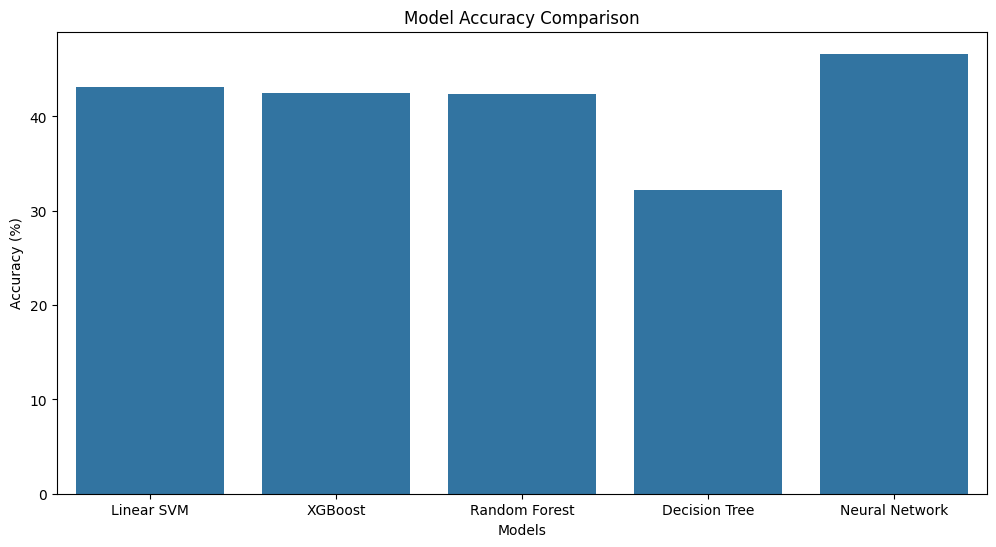

In [1308]:
# Plot the accuracies
plt.figure(figsize=(12, 6))
sns.barplot(x=models, y=accuracies)
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.xlabel('Models')
plt.show()

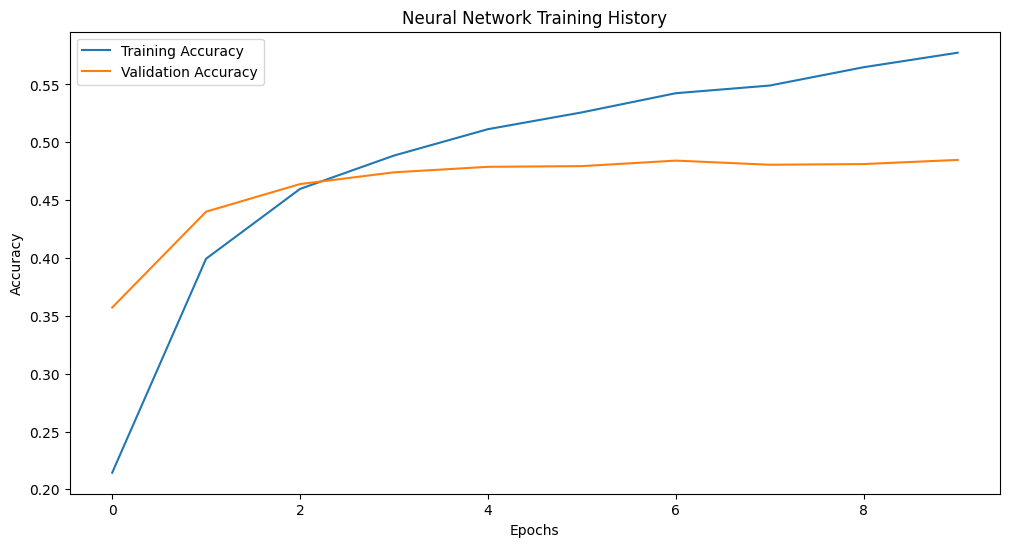

In [1309]:
# Visualize Neural Network Training History
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Neural Network Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

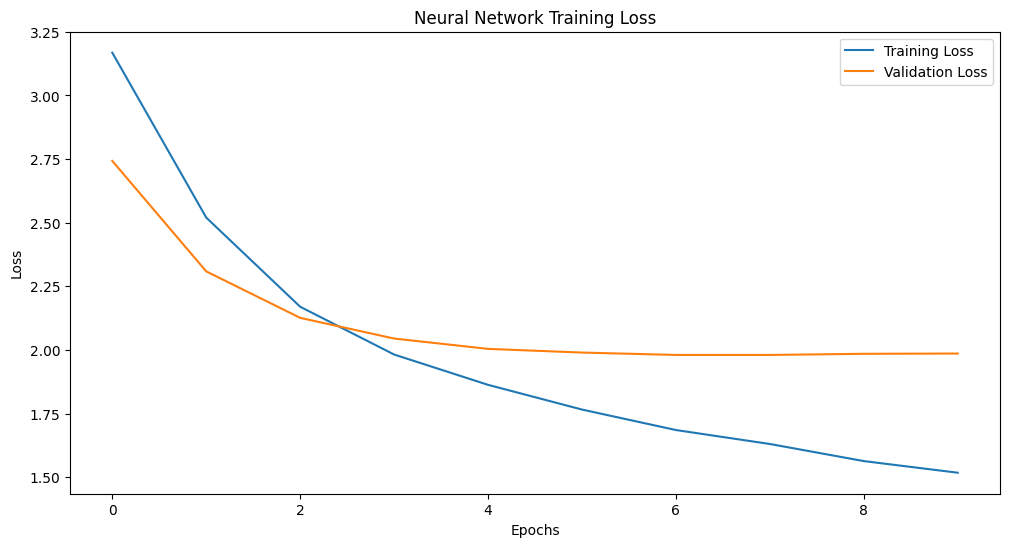

In [1310]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Neural Network Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [1311]:
nn_model.summary()

Model: "sequential_69"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_190 (Dense)               │ (None, 256)            │       256,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_120 (Dropout)           │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_191 (Dense)               │ (None, 42)             │        10,794 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 801,152 (3.06 MB)

 Trainable params: 267,050 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 534,102 (2.04 MB)

C:\Users\71548\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\71548\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\71548\AppData\Roaming\Python\Python312\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

                precision    recall  f1-score   support

          ARTS       0.25      0.14      0.18        29
ARTS & CULTURE       0.33      0.05      0.08        22
  BLACK VOICES       0.51      0.19      0.28       103
      BUSINESS       0.34      0.31      0.33       122
       COLLEGE       0.22      0.14      0.17        14
        COMEDY       0.32      0.18      0.23       100
         CRIME       0.39      0.47      0.43        68
CULTURE & ARTS       0.14      0.05      0.07        21
       DIVORCE       0.50      0.45      0.47        62
     EDUCATION       0.43      0.53      0.47        17
 ENTERTAINMENT       0.41      0.56      0.47       358
   ENVIRONMENT       0.18      0.07      0.10        29
         FIFTY       0.00      0.00      0.00        32
  FOOD & DRINK       0.43      0.54      0.48       128
     GOOD NEWS       0.00      0.00      0.00        31
         GREEN       0.20      0.16      0.18        55
HEALTHY LIVING       0.16      0.10      0.12  

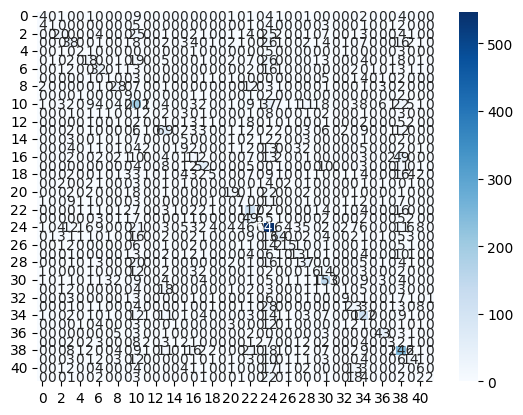

In [1312]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_test_classes, y_pred_nn_classes, target_names=le.classes_))
sns.heatmap(confusion_matrix(y_test_classes, y_pred_nn_classes), annot=True, fmt='d', cmap='Blues')
plt.show()
